# Sport in Social Media - Classification model based on bags of words

For this notebook I assume already cleaned data.

## Load libraries

In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
import string
import re
from nltk.stem.porter import PorterStemmer

from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## EDA and preparation of dataset

### Load and preview dataset

In [7]:
data = pd.read_csv('/content/drive/MyDrive/Assignments/NLP - Social Media/Labelled_text.csv')
data.head()

,text,label
0,Manchester MMA fighter Brendan Loughnane 21-3-...,mma
1,Former PFL women s lightweight champion Kayla ...,mma
2,Kayla Harrison is a perfectionist inside the c...,mma
3,Ciryl Gane stopped Derrick Lewis with a flurry...,mma
4,As Manchester's featherweight contender Brenda...,mma


In [8]:
data.shape

(21594, 2)

### Remove rows with na values if any

In [11]:
data.isna().sum(axis=0)

text     17
label     0
dtype: int64

In [12]:
data.dropna(inplace=True)

In [13]:
print(data.shape)
data.head()

(21577, 2)


,text,label
0,Manchester MMA fighter Brendan Loughnane 21-3-...,mma
1,Former PFL women s lightweight champion Kayla ...,mma
2,Kayla Harrison is a perfectionist inside the c...,mma
3,Ciryl Gane stopped Derrick Lewis with a flurry...,mma
4,As Manchester's featherweight contender Brenda...,mma


### Look at response 

In [16]:
data.groupby('label').size()

label
baseball       1965
basketball      928
boxing          563
cricket        1044
f1              458
football       2225
golf            276
hockey          229
mma             116
netball         319
nonsport       2336
other_sport    7686
rugby           866
soccer         2075
tennis          491
dtype: int64

In [17]:
data.label.nunique()

15

## Prepare data for analysis

### Preproces text

In [18]:
nltk.download('stopwords');
stop_words = stopwords.words('english')
porter = PorterStemmer()

def preprocess_text(text):
  text = re.sub(r'https?:\/\/.*[\r\n]*','',text)
  text = text.lower()
  text = "".join([char for char in text if char not in string.punctuation])
  text = " ".join([porter.stem(token) for token in text.split() if token not in stop_words])
  text = "".join([char for char in text if char.isalpha() or char==' ']) 
  return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
preprocessed_text=data.text.apply(preprocess_text)

In [20]:
preprocessed_text[0]

'manchest mma fighter brendan loughnan  take movlid khaybulaev dream becom featherweight pfl champion take away m  prize money fighter across featherweight light heavyweight divis aim make final four move one step closer becom pfl champion captur lifechang amount money loughnan russian khaybulaev clash featherweight contest friday fighter look first pfl championship berth pleas use chrome browser access video player brendan loughnan clinch spot pfl playoff hard fought major decis tyler diamond mad sound im even look money loughnan told sky sport ed draper world champion goal money come goe life alway piec gold ive work  year get anywher near  win tournament begin nobodi gave chanc stage toughest guy tournament want get way beat best guy stage done far impress fashion deserv belt money nice cherri top pleas use chrome browser access video player reliv excit moment pfl  season open featur big win clay collard marcin held bubba jenkin manchest loughnan loughnan current sevenfight winstrea

In [21]:
data.text[0]

'Manchester MMA fighter Brendan Loughnane 21-3-0 takes on Movlid Khaybulaev with dreams of becoming featherweight PFL champion and taking away 1m 730,000 in prize money. Fighters across the featherweight and light heavyweight divisions will be aiming to make it out of the final four and move one step closer to becoming a PFL champion and capturing a life-changing amount of money. Loughnane and Russian Khaybulaev will clash in a featherweight contest on Friday, with each fighter looking for their first PFL Championship berth. Please use Chrome browser for a more accessible video player Brendan Loughnane clinched a spot in the PFL playoffs with a hard fought majority decision over Tyler Diamond "As mad as it sounds I\'m not even looking at the money," Loughnane told Sky Sports\' Ed Draper. "To be a world champion is my goal. "Money comes and goes in your life and it always will do, but it\'s all about that piece of gold which I\'ve worked 13 years to get anywhere near this. I was 70-1 to

In [22]:
data['text'] = preprocessed_text

### Encode response

In [23]:
lb = LabelBinarizer()
y = lb.fit_transform(data.label)

In [24]:
y_labels = lb.classes_
y_labels

array(['baseball', 'basketball', 'boxing', 'cricket', 'f1', 'football',
       'golf', 'hockey', 'mma', 'netball', 'nonsport', 'other_sport',
       'rugby', 'soccer', 'tennis'], dtype='<U11')

### Split data into train and test

In [25]:
X_train, X_test, y_train, y_test = train_test_split(data.text,y, test_size=0.2, random_state=1,stratify=y)

### Create Bag of Word

In [26]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df=3)
vectorizer.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.5, max_features=None,
                min_df=3, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [27]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [28]:
print(vectorizer.get_feature_names()[:10])

['aaa', 'aac', 'aadvantag', 'aaefafffae', 'aap', 'aaron', 'ab', 'abandon', 'abba', 'abbatar']


In [29]:
print(X_train.shape)

(17261, 14824)


In [30]:
z=X_train[1, :].toarray().flatten().tolist()

In [31]:
x = [i for i in z if i > 0]
x[:10]

[0.22102628941609276,
 0.40075651237704674,
 0.2610491194413522,
 0.1810271538459755,
 0.30782321003526575,
 0.40075651237704674,
 0.22453201513905682,
 0.26964462040671877,
 0.25230623074747316,
 0.28309577422537496]

### Balance dataset

In [43]:
ros = RandomOverSampler(random_state=1)
X_train_over, y_train_over = ros.fit_resample(X_train,y_train)
X_test_over, y_test_over = ros.fit_resample(X_test,y_test)

rus = RandomUnderSampler(random_state=1)
X_train_under, y_train_under = rus.fit_resample(X_train,y_train)
X_test_under, y_test_under = rus.fit_resample(X_test,y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [44]:
print(X_train_over.shape, y_train_over.shape, X_test_over.shape, y_test_over.shape)
print(X_train_under.shape, y_train_under.shape, X_test_under.shape, y_test_under.shape)

(92235, 14824) (92235, 15) (23055, 14824) (23055, 15)
(1395, 14824) (1395, 15) (345, 14824) (345, 15)


## Create models

In [37]:
def print_metrics(model, X_train, y_train, X_test, y_test, X_test_balanced = None, y_test_balanced = None):
  dic = {}
  cv = np.mean(cross_val_score(model, X_train, y_train, cv = 5))
  dic['cv'] = cv
  print('Cross- Validation score: ', cv)
  dic['acc_b'] = None
  if X_test_balanced is not None and y_test_balanced is not None:
    acc_b = accuracy_score(y_test_balanced.argmax(axis=1),model.predict(X_test_balanced).argmax(axis=1))
    dic['acc_b'] = acc_b
    print('Accuracy on balanced test data: ', acc_b)
  acc = accuracy_score(y_test.argmax(axis=1),model.predict(X_test).argmax(axis=1))
  dic['acc'] = acc
  print('Accuracy on test data: ', acc)
  kappa = cohen_kappa_score(y_test.argmax(axis=1),model.predict(X_test).argmax(axis=1))
  dic['kappa'] = kappa
  print('Kappa on test data: ', kappa)
  return dic

### Undersampled data

In [45]:
clf_u = RandomForestClassifier(n_estimators=100, random_state=1)
clf_u.fit(X_train_under, y_train_under)

metrics_under = print_metrics(clf_u, X_train_under, y_train_under, X_test, y_test, X_test_under, y_test_under)

Cross- Validation score:  0.0
Accuracy on balanced test data:  0.2753623188405797
Accuracy on test data:  0.211306765523633
Kappa on test data:  0.12855920114122676


### Oversampled data

In [46]:
clf_o = RandomForestClassifier(n_estimators=100, random_state=1)
clf_o.fit(X_train_over, y_train_over)

metrics_over = print_metrics(clf_o, X_train_over, y_train_over, X_test, y_test, X_test_over, y_test_over)

Cross- Validation score:  0.9219927359462243
Accuracy on balanced test data:  0.43057905009759273
Accuracy on test data:  0.5108897126969416
Kappa on test data:  0.4203750067991334


### Original data

In [47]:
clf = RandomForestClassifier(n_estimators=100, random_state=1)
clf.fit(X_train, y_train)

metrics_original = print_metrics(clf, X_train, y_train, X_test, y_test)

Cross- Validation score:  0.4811426509066125
Accuracy on test data:  0.5382298424467099
Kappa on test data:  0.42838262519456705


### Evaluation of results

In [48]:
scores = pd.DataFrame(metrics_under, index=[0]).append(metrics_over,ignore_index=True).append(metrics_original,ignore_index=True)
scores = scores.rename({0:'Under Sampling',1:'Over Sampling',2:'No Sampling'})
scores

,cv,acc_b,acc,kappa
Under Sampling,0.000000,0.275362,0.211307,0.128559
Over Sampling,0.921993,0.430579,0.510890,0.420375
No Sampling,0.481143,NaN,0.538230,0.428383


Model trained on original dataset gave the best results, so lets check results.

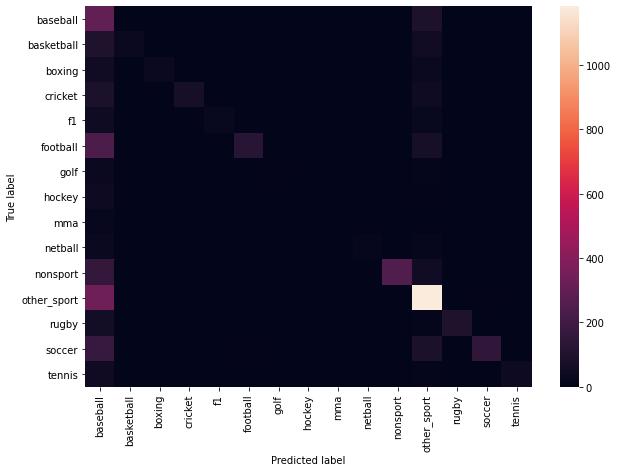

In [53]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))
plt.figure(figsize = (10,7))
sns.heatmap(cm, xticklabels=y_labels, yticklabels=y_labels);
plt.ylabel('True label');
plt.xlabel('Predicted label');

On original test set other_sport category shadows remainin categories.

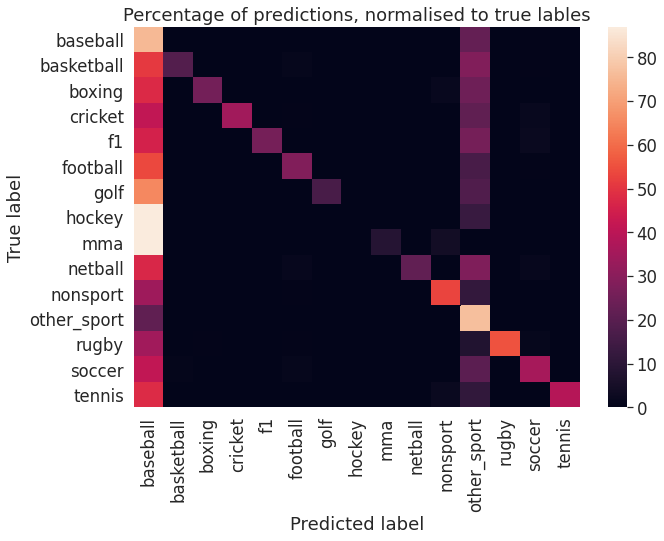

In [54]:
def my_func(a):
    return a/sum(a)*100

cm = np.apply_along_axis(my_func, 1, cm)

sns.set(font_scale=1.5)
plt.figure(figsize = (10,7))
sns.heatmap(cm, xticklabels=y_labels, yticklabels=y_labels);
plt.ylabel('True label');
plt.xlabel('Predicted label');
plt.title('Percentage of predictions, normalised to true lables');

Normalized results along true values shows that baseball discipline is main misclassification for remaining classes. Sport categories with small number of instancess seems to completelly misclassified to baseball category.

## Conclusions

- Our model gave very poor results, probably due to noise in data and/or differences in text, like lenght and their source.